<a href="https://colab.research.google.com/github/Suman-Regmi/Plastic_Hinges/blob/main/newPlasticHinging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# The code has been changed!
%%capture
!pip install openseespy opsvis
from openseespy import opensees as ops
from itertools import product
import opsvis
import numpy as np

In [ ]:
N = 1
kN = 1000*N
m = 1
mm = 1/1000 * m
kg = N/9.81

In [ ]:
ops.wipe()
ops.model("Basic","-ndm",2,"-ndf",3)
x = [0,5,10]
y = [0,5,10]

XY = list(product(x,y))

[ops.node(100 + count, i, j) for count,(i,j) in enumerate(XY)]

ops.fixY(0,1,1,1)


In [ ]:
E = 5000*np.sqrt(25) * N/mm**2
Abeam =  0.35 * 0.23 * m**2
Ibeam = 0.35**3 * 0.23 * m**4/12
E = 5000*np.sqrt(25) * N/mm**2
Acolumn =  0.35 * 0.35 * m**2
Icolumn = 0.35**3 * 0.35 * m**4/12
I = 1
transfTag  =1

In [ ]:
ops.geomTransf("Corotational",transfTag)
storeyNodes = {storey+1 : [nodes for nodes in ops.getNodeTags() if ops.nodeCoord(nodes)[1] == level] for storey,level in enumerate(y[1:]) }
Xnodes = {storey : [nodes for nodes in ops.getNodeTags() if ops.nodeCoord(nodes)[0] == level] for storey,level in enumerate(x) }
beamConnection = [[rows[i],rows[i+1]] for rows in storeyNodes.values() for i in range(len(rows)-1)]
columnConnection = [[columns[i],columns[i+1]] for columns in Xnodes.values() for i in range(len(columns)-1)]

In [ ]:
[ops.element("elasticBeamColumn",count, i, j , Abeam, E, Ibeam, transfTag) for  count,(i,j) in enumerate(beamConnection)]
eleBeams = len(ops.getEleTags())
[ops.element("elasticBeamColumn",eleBeams + count, i, j , Acolumn, E, Icolumn, transfTag) for  count,(i,j) in enumerate(columnConnection)]

[None, None, None, None, None, None]

In [ ]:
for i in storeyNodes.values():
  print(i)

[101, 104, 107]
[102, 105, 108]


In [ ]:
beamConnection

[[101, 104], [104, 107], [102, 105], [105, 108]]

In [ ]:
columnConnection
allBCconnection = np.array(beamConnection + columnConnection)

In [ ]:
noZerolengthsbeam = np.ravel(beamConnection).tolist()
noZerolengthscolumn = np.ravel(columnConnection).tolist()

nodeTagsBeam = [[9000+i,ops.node(9000+ i,*ops.nodeCoord(i))] if not 9000+i in ops.getNodeTags() else [10000+i,ops.node(10000+ i,*ops.nodeCoord(i))] for i in noZerolengthsbeam ]
nodeTagsColumn = [[19000+i,ops.node(19000+ i,*ops.nodeCoord(i))] if not 19000+i in ops.getNodeTags() else [20000+i,ops.node(20000+ i,*ops.nodeCoord(i))] for i in noZerolengthscolumn ]
# This line needs to be edited!
# nodeTagsBeam = [[nodeTagsBeam[count][0], nodeTagsBeam[count+1][0]] for count in range(len(nodeTagsBeam)-1) if not nodeTagsBeam[count][0] == nodeTagsBeam[count+1][0] or (not count%(len(x)-1) == 0 and not count/(len(x))-1) == 1 ]
#Barrier
nodeTagsBeam = [[nodeTagsBeam[count][0], nodeTagsBeam[count+1][0]] for count in range(len(nodeTagsBeam)-1) if not nodeTagsBeam[count][0] == nodeTagsBeam[count+1][0] ]
nodeTagsColumn = [[nodeTagsColumn[count][0], nodeTagsColumn[count+1][0]] for count in range(len(nodeTagsColumn)-1) if not nodeTagsColumn[count][0] == nodeTagsColumn[count+1][0]]




In [ ]:
nodeTagsBeam

nodeTagsColumn

[[19100, 19101],
 [19101, 20101],
 [20101, 19102],
 [19102, 19103],
 [19103, 19104],
 [19104, 20104],
 [20104, 19105],
 [19105, 19106],
 [19106, 19107],
 [19107, 20107],
 [20107, 19108]]

<Axes: >

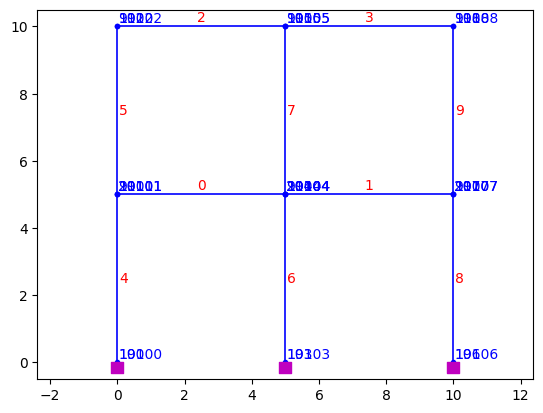

In [ ]:
opsvis.plot_model()

In [ ]:
nodeTagsBeam = [nodeTagsBeam[i] for i in range(0,len(nodeTagsBeam)) if i % 2 != 1]
# result.insert(0,nodeTagsBeam[0])
nodeTagsColumn = [nodeTagsColumn[i]  for i in range(len(nodeTagsColumn))  if i % 2 != 1 ]
nodeTagsBeam

[[9101, 9104], [10104, 9107], [9102, 9105], [10105, 9108]]

In [ ]:
for i in range(len(ops.getEleTags())):
    ops.remove("element",i)

{101: 9081.931702344546, 104: 9594.80122324159, 107: 9081.931702344546, 102: 8301.478083588176, 105: 8814.347604485218, 108: 8301.478083588176}


<Axes: >

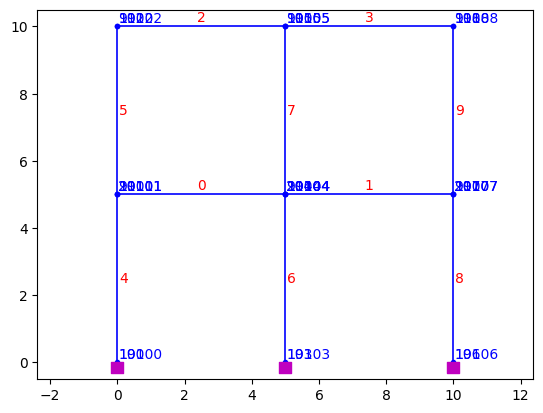

In [ ]:
N_spring = 10

eleBeamTags = []
eleColumnTags = []
for  count,(i,j) in enumerate(nodeTagsBeam):
  ops.element("elasticBeamColumn",count, i, j , Abeam, E, Ibeam*(N_spring+1)/N_spring, transfTag)
  eleBeamTags.append(count)
eleBeams = len(ops.getEleTags())
for  count,(i,j) in enumerate(nodeTagsColumn):
  ops.element("elasticBeamColumn",eleBeams + count, i, j , Acolumn, E, Icolumn*(N_spring+1)/N_spring, transfTag)
  eleColumnTags.append(eleBeams + count)

DeadLoadPattern = 1
DeadLoadTimeSeries = 1
roomLive = 2.0*kN/m**2
roomDead = 3.5*kN/m**2
roomTotal = roomLive + roomDead
roomTributary = 2*2.5*m
ops.timeSeries("Constant", DeadLoadTimeSeries)
ops.pattern("Plain",DeadLoadPattern,DeadLoadTimeSeries)
unitWeightConc = 25*kN/m**3
lengthBeam = 5*m
lengthColumn = 5*m
colSpringStiffness = N_spring*6*E*Icolumn/lengthColumn
beamSpringStiffness = N_spring*6*E*Ibeam/lengthBeam

for ele in eleBeamTags:
    ops.eleLoad("-ele", ele,"-type","-beamUniform", -unitWeightConc* Abeam - roomTotal*roomTributary )
for ele in eleColumnTags:
    ops.eleLoad("-ele", ele,"-type","-beamUniform", 0.0,-unitWeightConc* Acolumn )
Initial_nodes = np.array([i for i in ops.getNodeTags() if not ops.nodeCoord(i)[1] == 0.0])
massNodes = np.zeros(shape = sum((Initial_nodes)<200)+1)
Initial_nodes = Initial_nodes[Initial_nodes<200]
# massNodes = np.zeros(sum(Initial_nodes)<200+1)


beamMassCount = {nodes : np.ravel(beamConnection).ravel().tolist().count(nodes) for nodes in np.ravel(beamConnection).ravel().tolist()}
columnMassCount = {nodes : np.ravel(columnConnection).ravel().tolist().count(nodes) for nodes in np.ravel(columnConnection).ravel().tolist()}

beamMass = {nodes: beamMassCount[nodes]*unitWeightConc*Abeam*kg*lengthBeam/2 + roomTotal*roomTributary * kg * lengthBeam/2 for nodes in beamMassCount }
columnMass = {nodes: columnMassCount[nodes]*unitWeightConc*Acolumn*kg*lengthColumn/2 for nodes in columnMassCount}
from collections import defaultdict

nodeMass = {nodes: beamMass[nodes]+ columnMass[nodes] for nodes in beamMass}
print(nodeMass)
# Assign mass to the nodes in Initial_nodes
# for nodeTag in Initial_nodes:
#     sumBeam = np.sum(np.array(beamConnection).ravel()== nodeTag)
#     print(sumBeam, nodeTag)
#     massNodes[nodeTag-100] = Abeam * unitWeightConc * kg * lengthBeam/2 * sumBeam + roomTotal*roomTributary * kg * lengthBeam/2
#     sumColumn = np.sum(np.array(columnConnection).ravel()== nodeTag)
#     massNodes[nodeTag-100] += Acolumn * unitWeightConc * kg * lengthColumn/2 * sumColumn
# for mass,node in zip(massNodes[ops.getNodeTags()-100],ops.getNodeTags()):
#     ops.mass(node,mass,0.,0.)
for nodes in nodeMass:
  ops.mass(nodes, nodeMass[nodes],nodeMass[nodes]*1e-9,1e-9) #Considering negligible mass also along vertical
# opsvis.plot_loads_2d(17, True)
# print(massNodes)

# print(Initial_nodes)


opsvis.plot_model()

In [ ]:
sameNodes = {node: [slaveNodes for slaveNodes in ops.getNodeTags() if slaveNodes>9000 and ops.nodeCoord(node) == ops.nodeCoord(slaveNodes)] for node in ops.getNodeTags()  if node<9000}

In [ ]:
# for storey in storeyNodes:
#   for slaveNodes in storeyNodes[storey][1:]:
#     ops.equalDOF(storeyNodes[storey][0],slaveNodes,1,2)
[ops.equalDOF(node, slaveNodes,1,2) for node in sameNodes for slaveNodes in sameNodes[node]]
sameNodes

{100: [19100],
 101: [9101, 19101, 20101],
 102: [9102, 19102],
 103: [19103],
 104: [9104, 10104, 19104, 20104],
 105: [9105, 10105, 19105],
 106: [19106],
 107: [9107, 19107, 20107],
 108: [9108, 19108]}

In [ ]:
[{i : ops.nodeMass(i)} for i in sameNodes]

[{100: [0.0, 0.0, 0.0]},
 {101: [9081.931702344546, 9.081931702344546e-06, 1e-09]},
 {102: [8301.478083588176, 8.301478083588176e-06, 1e-09]},
 {103: [0.0, 0.0, 0.0]},
 {104: [9594.80122324159, 9.59480122324159e-06, 1e-09]},
 {105: [8814.347604485218, 8.814347604485219e-06, 1e-09]},
 {106: [0.0, 0.0, 0.0]},
 {107: [9081.931702344546, 9.081931702344546e-06, 1e-09]},
 {108: [8301.478083588176, 8.301478083588176e-06, 1e-09]}]

In [ ]:
storey = {count+1: [nodes for nodes in ops.getNodeTags() if ops.nodeCoord(nodes)[1] == (count+1)*lengthColumn] for count in range(-1,len(y)-1)}

In [ ]:
# ops.system("FullGeneral")
# ops.eigen("-fullGenLapack",1)

len(storey[1]) == 3+4+3 + 3

True

In [ ]:
# for count in storey:
#   for slaveNodes in storey[count][1:]:
#     ops.equalDOF(storey[count][0],slaveNodes,1,2)

storeyNodes

{1: [101, 104, 107], 2: [102, 105, 108]}

In [ ]:
colSpring = 1
beamSpring = 2
# ops.uniaxialMaterial("Elastic",colSpring,colSpringStiffness)
# ops.uniaxialMaterial("Elastic",beamSpring,beamSpringStiffness)
ops.uniaxialMaterial("ElasticPP",colSpring,colSpringStiffness,0.005)
ops.uniaxialMaterial("ElasticPP",beamSpring,beamSpringStiffness,0.005)

for count,(i,j) in enumerate(zip(beamConnection,nodeTagsBeam)):
  ops.element("zeroLength",1000+2*count, i[0], j[0], "-mat",beamSpring,"-dir",3)
  ops.element("zeroLength",1000+2*count+1, j[1], i[1], "-mat",beamSpring,"-dir",3)
for count,(i,j) in enumerate(zip(columnConnection,nodeTagsColumn)):
  ops.element("zeroLength",1100+2*count, i[0], j[0], "-mat",colSpring,"-dir",3)
  ops.element("zeroLength",1100+2*count+1, j[1], i[1], "-mat",colSpring,"-dir",3)




In [ ]:
for count,(i,j) in enumerate(zip(beamConnection,nodeTagsBeam)):
  print({count:(i,j)})

{0: ([101, 104], [9101, 9104])}
{1: ([104, 107], [10104, 9107])}
{2: ([102, 105], [9102, 9105])}
{3: ([105, 108], [10105, 9108])}


In [ ]:
ops.system("FullGeneral")
ops.constraints("Transformation")
2*np.pi/np.sqrt(ops.eigen("-fullGenLapack",2))

array([0.79382094, 0.24693225])

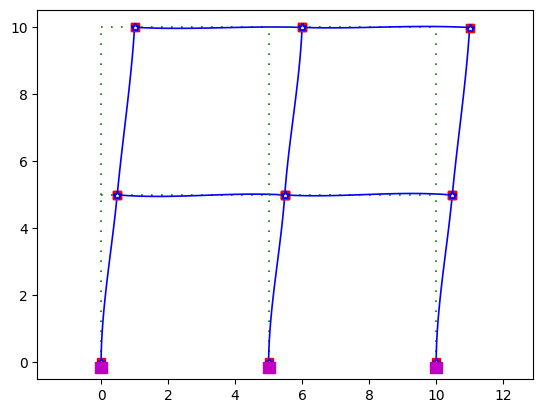

In [ ]:
opsvis.plot_mode_shape(1)

In [ ]:
ops.constraints("Transformation")
ops.numberer("Plain")
ops.system("FullGeneral")
ops.test("NormDispIncr",1e-5,1000)

ops.integrator("LoadControl",0.1)
ops.algorithm("Newton")
ops.analysis("Static")
# ops.remove("node",10104)
ops.analyze(10)
stiffness = ops.printA("-ret")

In [ ]:
stiffness  = np.array(stiffness)
stiffness.shape = [int(ops.systemSize()),int(ops.systemSize())]


# failedDOF = 1


# for node in ops.getNodeTags():
#   if failedDOF in ops.nodeDOFs(node):
#     print({node: ops.nodeCoord(node)})
# for ele in ops.getEleTags():
#   for nodes in ops.eleNodes(ele):
#     if failedDOF in ops.nodeDOFs(nodes):
#       print(ele)

In [ ]:
"""# determine stiffness modifications to equate the stiffness of the spring-elastic element-spring subassembly to the stiffness of the actual frame member
	# Reference:  Ibarra, L. F., and Krawinkler, H. (2005). "Global collapse of frame structures under seismic excitations," Technical Report 152,
	#             The John A. Blume Earthquake Engineering Research Center, Department of Civil Engineering, Stanford University, Stanford, CA.
	# calculate modified section properties to account for spring stiffness being in series with the elastic element stiffness
	set n 10.0;		# stiffness multiplier for rotational spring

	# calculate modified moment of inertia for elastic elements
	set Icol_12mod  [expr $Icol_12*($n+1.0)/$n];	# modified moment of inertia for columns in Story 1 & 2
	set  oment of inertia for beams in Floor 2 & 3
	# calculate modified rotational stiffness for plastic hinge springs
	set Ks_col_1   [expr $n*6.0*$Es*$Icol_12mod/$HStory1];		# rotational stiffness of Story 1 column springs
	set Ks_col_2   [expr $n*6.0*$Es*$Icol_12mod/$HStoryTyp];	# rotational stiffness of Story 2 column springs
	set Ks_beam_23 [expr $n*6.0*$Es*$Ibeam_23mod/$WBay];		# rotational stiffness of Floor 2 & 3 beam springs

# set up geometric transformations of element
	set PDeltaTransf 1;
	geomTransf PDelta $PDeltaTransf; 	# PDelta transformation

# define elastic column elements using "element" command
	# command: element elasticBeamColumn $eleID $iNode $jNode $A $E $I $transfID
	# eleID convention:  "1xy" where 1 = col, x = Pier #, y = Story #
	# Columns Story 1
	element elasticBeamColumn  111  117 126 $Acol_12 $Es $Icol_12mod $PDeltaTransf;	# Pier 1
	element elasticBeamColumn  121  217 226 $Acol_12 $Es $Icol_12mod $PDeltaTransf;	# Pier 2
	# Columns Story 2
	element elasticBeamColumn  112  127 136 $Acol_12 $Es $Icol_12mod $PDeltaTransf;	# Pier 1
	element elasticBeamColumn  122  227 236 $Acol_12 $Es $Icol_12mod $PDeltaTransf;	# Pier 2"""

'# determine stiffness modifications to equate the stiffness of the spring-elastic element-spring subassembly to the stiffness of the actual frame member\n\t# Reference:  Ibarra, L. F., and Krawinkler, H. (2005). "Global collapse of frame structures under seismic excitations," Technical Report 152,\n\t#             The John A. Blume Earthquake Engineering Research Center, Department of Civil Engineering, Stanford University, Stanford, CA.\n\t# calculate modified section properties to account for spring stiffness being in series with the elastic element stiffness\n\tset n 10.0;\t\t# stiffness multiplier for rotational spring\n\n\t# calculate modified moment of inertia for elastic elements\n\tset Icol_12mod  [expr $Icol_12*($n+1.0)/$n];\t# modified moment of inertia for columns in Story 1 & 2\n\tset  oment of inertia for beams in Floor 2 & 3\n\t# calculate modified rotational stiffness for plastic hinge springs\n\tset Ks_col_1   [expr $n*6.0*$Es*$Icol_12mod/$HStory1];\t\t# rotational sti

In [ ]:
from prettytable import PrettyTable

# Example array
array = np.array([[1.123456789, 2.123456789, 3.123456789],
                  [4.123456789, 5.123456789, 6.123456789]])

# Create PrettyTable
table = PrettyTable()
table.field_names = [f"Col {i}" for i in range(stiffness.shape[1])]

for row in stiffness:
    table.add_row([f"{x:.3f}" for x in row])

# Print PrettyT
print(table)

+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+---------------+----------------+----------------+---------------+----------------+----------------+---------------+----------------+----------------+----------------+----------------+----------------+
|     Col 0      |     Col 1      |     Col 2      |     Col 3      |     Col 4      |     Col 5      |     Col 6      |     Col 7      |     Col 8      |     Col 9      |     Col 10     |     Col 11     |     Col 12     |     Col 13     |     Col 14     |     Col 15     |     Col 16     |     Col 17     |     Col 18     |     Col 19     |     Col 20   

In [ ]:
dofswithZeroStiffness = []
for i in range(stiffness.shape[0]):
  if stiffness[i,i] == 0:
    dofswithZeroStiffness.append(i)

In [ ]:
ops.loadConst("-time")
ops.wipeAnalysis()

pushoverTimeSeries = 2
pushoverPattern = 2
ops.remove("timeSeries", pushoverTimeSeries)
ops.remove("loadPattern", pushoverTimeSeries)
ops.timeSeries("Linear",pushoverTimeSeries)
ops.pattern("Plain",pushoverPattern, pushoverTimeSeries)
ops.load(101, 1*kN, 0,0)
ops.load(102, 1*kN, 0,0)


ops.constraints("Transformation")
ops.numberer("Plain")
ops.system("FullGeneral")
ops.test("NormDispIncr",1e-8,1000)
maxDisp = 2000 * mm
numSteps = 1000
dk =  maxDisp / numSteps
ops.integrator("DisplacementControl",102,1,dk,1,1)
ops.algorithm("Newton")
ops.analysis("Static")
loadFactor = []
disp = []
targetNode = 102
zeroLengthForce = {i:[] for i in ops.getEleTags() if i>=1000}
baseShear = []
while(ops.nodeDisp(targetNode,1) < maxDisp):
  ops.analyze(1,dk)
  ops.reactions()
  loadFactor.append(ops.getLoadFactor(pushoverPattern))
  disp.append(ops.nodeDisp(targetNode,1))
  [zeroLengthForce[i].append(ops.eleResponse(i, "deformation")) for i in zeroLengthForce]



Text(0.5, 1.0, 'Pushover Curve')

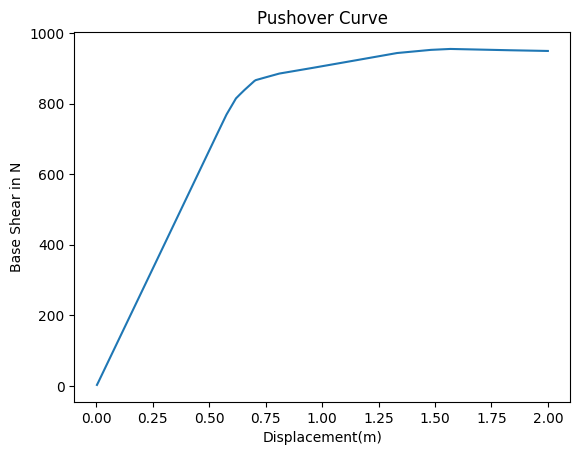

In [ ]:
from matplotlib import pyplot as plt
plt.plot(disp, loadFactor)
plt.xlabel("Displacement(m)")
plt.ylabel("Base Shear in N")
plt.title("Pushover Curve")

0.49999102773750337

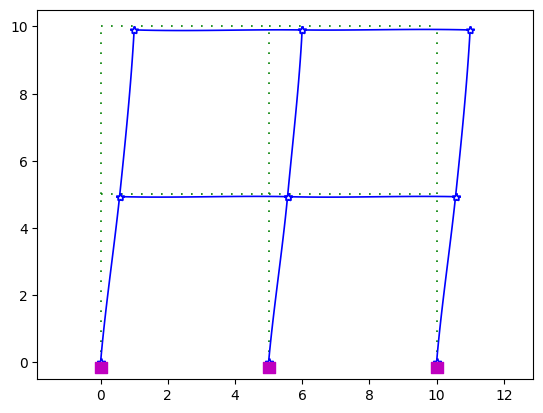

In [ ]:
opsvis.plot_defo()

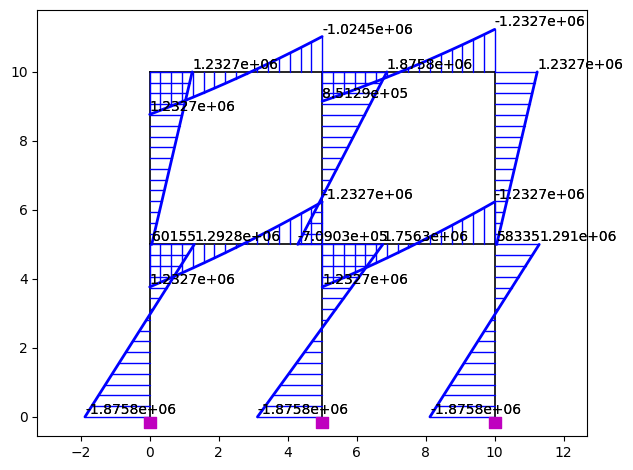

In [ ]:
opsvis.section_force_diagram_2d("M",sfac = 0.000001)
plt.tight_layout()

In [ ]:
ops.nodeDisp(102,3)


-0.11010709867070306

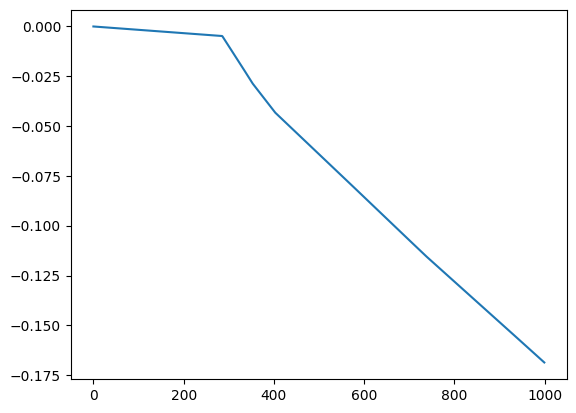

In [ ]:
plt.plot( zeroLengthForce[1003] )

In [ ]:
ops.nodeReaction(106)

[0.0, 0.0, 1875781.2499999995]

In [ ]:
11*0.03/(11-11*0.03)

0.03092783505154639

In [ ]:
11